# Car Object Detection AI

## Libraries

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import shutil as sh
import csv

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

import tensorflow as tf

## Data Loading

In [2]:
solutionBox = pd.read_csv('./data/train_solution_bounding_boxes.csv')
print(solutionBox.dtypes)
print(solutionBox.shape)

image     object
xmin     float64
ymin     float64
xmax     float64
ymax     float64
dtype: object
(559, 5)


In [3]:
img_h, img_w, num_channels = (380, 676, 3)
solutionBox['image'] = solutionBox['image'].apply(lambda x: x.split('.')[0])
solutionBox['x_center'] = (solutionBox['xmin'] + solutionBox['xmax'])/2
solutionBox['y_center'] = (solutionBox['ymin'] + solutionBox['ymax'])/2
solutionBox['w'] = solutionBox['xmax'] - solutionBox['xmin']
solutionBox['h'] = solutionBox['ymax'] - solutionBox['ymin']
solutionBox['classes'] = 0
solutionBox['x_center'] = solutionBox['x_center']/img_w
solutionBox['w'] = solutionBox['w']/img_w
solutionBox['y_center'] = solutionBox['y_center']/img_h
solutionBox['h'] = solutionBox['h']/img_h
print(solutionBox.head())

         image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0  


In [4]:
index = list(set(solutionBox.image))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'./data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_16400


(380, 676, 3)

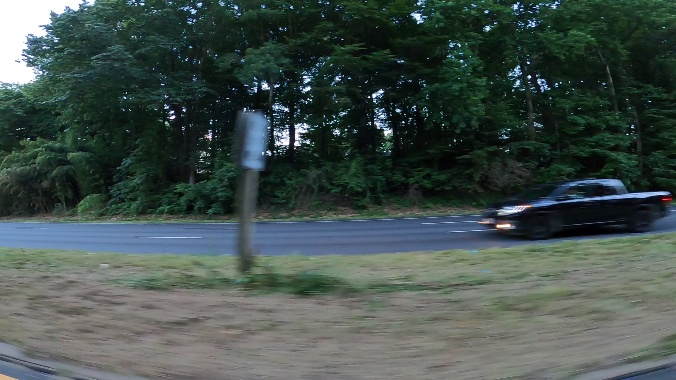

In [5]:
image = random.choice(index)
Image(filename=f'./data/training_images/{image}.jpg',width=600)

## Training

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have x_center, y_center, w, h values

In [6]:
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(solutionBox.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['x_center','y_center','w','h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/training_images/{}.jpg".format(name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1172.07it/s]


In [7]:
IMG_SIZE = 500

In [8]:
training_data = []

def create_training_data():
    count = 0
    for i in range(len(os.listdir('./tmp/images/train'))):
        for img in os.listdir('./tmp/images/train'):
            img_array = cv2.imread('./tmp/images/train/'+img)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        for label in os.listdir('./tmp/labels/train'):
            with open('./tmp/labels/train/'+label) as file:
                label_array = file.read().splitlines()
        training_data.append([new_array, label_array])
        count += 1
    print(count)

create_training_data()

355


In [9]:
val_data = []

def create_val_data():
    count = 0
    for i in range(len(os.listdir('./tmp/images/val'))):
        for img in os.listdir('./tmp/images/val'):
            img_array = cv2.imread('./tmp/images/val/'+img)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        for label in os.listdir('./tmp/labels/val'):
            with open('./tmp/labels/val/'+label) as file:
                label_array = file.read().splitlines()
        val_data.append([new_array, label_array])
        count += 1
    print(count)

create_val_data()

287


In [10]:
test_data = []

def create_test_data():
    for img in os.listdir('./data/testing_images'):
        img_array = cv2.imread('./data/testing_images/'+img)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        test_data.append(new_array)

create_test_data()

In [11]:
random.shuffle(training_data)
random.shuffle(val_data)
random.shuffle(test_data)

In [12]:
x_train = []
y_train = []
for features, label in training_data:
    x_train.append(features)
    y_train.append(label)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

temp = np.array(y_train)
for i in range(len(temp)):
    y_train[i] = temp[i][0].split(' ')
y_train = np.array(y_train).astype(float)

print(x_train.shape, y_train.shape)

(355, 500, 500, 3) (355, 4)


In [13]:
x_val = []
y_val = []
for features, label in val_data:
    x_val.append(features)
    y_val.append(label)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

temp = np.array(y_val)
for i in range(len(temp)):
    y_val[i] = temp[i][0].split(' ')
y_val = np.array(y_val).astype(float)

print(x_val.shape, y_val.shape)

(287, 500, 500, 3) (287, 4)


In [14]:
x_test = []
y_test = np.empty([175, 4], dtype=float)
for features in test_data:
    x_test.append(features)

x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)


print(x_test.shape, y_test.shape)

(175, 500, 500, 3) (175, 4)


In [15]:
print(y_train[0], y_val[0])
print(y_train[1], y_val[1])
print(y_train[2], y_val[2])

[0.7425346  0.52902364 0.18426803 0.10751295] [0.05390738 0.56426963 0.10781476 0.1029601 ]
[0.7425346  0.52902364 0.18426803 0.10751295] [0.05390738 0.56426963 0.10781476 0.1029601 ]
[0.7425346  0.52902364 0.18426803 0.10751295] [0.05390738 0.56426963 0.10781476 0.1029601 ]


In [16]:
print(len(x_test))

175


In [17]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units = 64, activation='relu'))
model.add(tf.keras.layers.Dense(units = 4, activation='sigmoid'))

print(model.summary())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 968256)            0         
                                         

2022-04-17 20:22:39.173135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-17 20:22:39.173288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 50

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
NAME = 'Car-Object-Detection-{}'.format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data = (x_val, y_val), callbacks=[tensorboard, early_stop, model_save])

# plt.rcParams["figure.figsize"] = (20,10)

# # accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='lower right')
# plt.show()

# # loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Epoch 1/50


2022-04-17 20:22:39.485813: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-17 20:22:39.636465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 41s - loss: 2.0773 - accuracy: 1.0000

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x3716da8a0>
    label = <none> 
    device = <AGXG13XDevice: 0x17588be00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1304a9a00>
        label = <none> 
        device = <AGXG13XDevice: 0x17588be00>
            name = Apple M1 Pro 
    retainedReferences = 1


12/12 [==============================] - ETA: 0s - loss: 451.2071 - accuracy: 0.5493

2022-04-17 20:22:59.415647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 27s 2s/step - loss: 451.2071 - accuracy: 0.5493 - val_loss: 0.6382 - val_accuracy: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 24s 2s/step - loss: 0.6700 - accuracy: 1.0000 - val_loss: 0.6907 - val_accuracy: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 23s 2s/step - loss: 0.6633 - accuracy: 1.0000 - val_loss: 0.6855 - val_accuracy: 0.0000e+00
Epoch 4/50
12/12 [==============================] - 23s 2s/step - loss: 0.5492 - accuracy: 1.0000 - val_loss: 0.7085 - val_accuracy: 0.0000e+00
Epoch 4: early stopping
TRAINING SET
Loss: 0.6523351669311523 
Accuracy: 1.0

VALIDATION SET
Loss: 0.638225257396698 
Accuracy: 0.0

TEST SET
Loss: nan 
Accuracy: 0.8114285469055176


./data/training_images/vid_4_17320.jpg
(264, 216) (385, 463)


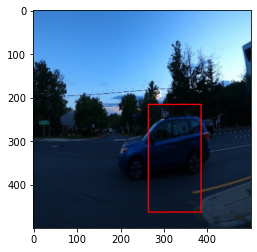

In [61]:
index = list(set(solutionBox.image))
random_img = random.choice(index)
filepath = './data/training_images/{}.jpg'.format(random_img)
print(filepath)

def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

prediction = model.predict([prepare(filepath)])
photo = plt.imread(filepath)
photo = cv2.resize(photo, (IMG_SIZE, IMG_SIZE))


point1 = int(prediction[0][0]*IMG_SIZE), int(prediction[0][1]*IMG_SIZE)
point2 = int((prediction[0][0]+prediction[0][2])*IMG_SIZE), int((prediction[0][1]+prediction[0][3])*IMG_SIZE)
color = (255,0,0)
thickness = 2

print(point1, point2)

cv2.rectangle(photo, point1, point2, color, thickness)
plt.figure()
plt.imshow(photo)